### 라이브러리 불러오기

In [44]:
import mysql.connector
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd

#시각화 관련
from matplotlib import rc
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import seaborn as sns
import warnings


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score


### 데이터 가져오기

In [2]:
# 기본 설정
load_dotenv()

warnings.filterwarnings('ignore')

font_path = os.getenv('FONT_PATH')
font_prop = font_manager.FontProperties(fname = font_path)

rc('font', family = font_prop.get_name())

plt.rcParams['axes.unicode_minus'] = False

In [3]:
host_ip = os.getenv('host_ip')
DATABASE = os.getenv('DATABASE')
user_id = os.getenv('user_id')
user_password = os.getenv('user_password')

# MySQl 연결
conn = mysql.connector.connect(
    host = host_ip, #localhost 또는 EC2의 EIP
    user = user_id,
    password = user_password,
    database = DATABASE
)
conn


In [4]:
# 커서 생성
cursor = conn.cursor(buffered=True)

# 쿼리 실행
cursor.execute("SELECT * FROM tbAPTPrice;")

# 데이터를 Pandas DataFrame으로 변환
columns = [desc[0] for desc in cursor.description]  # 컬럼명 가져오기
data = cursor.fetchall()  # 데이터 가져오기

df_tbAPTPrice = pd.DataFrame(data, columns=columns)  # DataFrame 생성

# DataFrame 출력
print(df_tbAPTPrice)

# 커넥션 닫기
cursor.close()

        접수연도  자치구코드  자치구명  법정동코드 법정동명 지번구분 지번구분명    본번    부번           건물명  \
0       2017  11710   송파구  10500  석촌동    1    대지  0282  0000          은하빌라   
1       2017  11560  영등포구  13200  신길동                                        
2       2017  11230  동대문구  10600  장안동    1    대지  0336  0000  장안현대홈타운(336)   
3       2017  11590   동작구  10200  상도동                                        
4       2017  11500   강서구  10300  화곡동    1    대지  0330  0043         예지빌라트   
...      ...    ...   ...    ...  ...  ...   ...   ...   ...           ...   
856306  2024  11680   강남구  10100  역삼동                                        
856307  2024  11290   성북구  13500  종암동    1    대지  0134  0000        래미안라센트   
856308  2024  11260   중랑구  10400   묵동    1    대지  0020  0000       신내대림아파트   
856309  2024  11680   강남구  11800  도곡동    1    대지  0967  0000            경남   
856310  2024  11620   관악구  10100  봉천동    1    대지  1712  0000      관악드림(동아)   

        ... 토지면적_m2   층 권리구분 취소일  건축년도   건물용도  신고구분 신고_공인중개사_지역

True

In [5]:
df = df_tbAPTPrice.copy()

### 탐색적 데이터 분석 및 전처리

In [6]:
df.head(3)

,접수연도,자치구코드,자치구명,법정동코드,법정동명,지번구분,지번구분명,본번,부번,건물명,...,토지면적_m2,층,권리구분,취소일,건축년도,건물용도,신고구분,신고_공인중개사_지역,계약일_DATE,idx
0,2017,11710,송파구,10500,석촌동,1,대지,0282,0000,은하빌라,...,36,3,,,2004,연립다세대,,,2017-08-08,1
1,2017,11560,영등포구,13200,신길동,,,,,,...,86,,,,1992,단독다가구,,,2017-08-08,2
2,2017,11230,동대문구,10600,장안동,1,대지,0336,0000,장안현대홈타운(336),...,0,15,,,2003,아파트,,,2017-08-08,3


#### 컬럼명 영문화

In [7]:
kor_col_list = df_tbAPTPrice.columns.to_list()
eng_col_list = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area',  'contract_date', 'idx']

In [8]:
df = df.rename(columns = {i:j for i,j in zip(kor_col_list, eng_col_list)})
df

,sumbit_year,jachigu_code,jachigu_name,law_code,law_name,jibun_gubun,jibun_name,real_num,extra_num,building_name,...,land_size,floor,right_gubun,cancel_date,building_year,building_usage,singo_gubun,agent_area,contract_date,idx
0,2017,11710,송파구,10500,석촌동,1,대지,0282,0000,은하빌라,...,36,3,,,2004,연립다세대,,,2017-08-08,1
1,2017,11560,영등포구,13200,신길동,,,,,,...,86,,,,1992,단독다가구,,,2017-08-08,2
2,2017,11230,동대문구,10600,장안동,1,대지,0336,0000,장안현대홈타운(336),...,0,15,,,2003,아파트,,,2017-08-08,3
3,2017,11590,동작구,10200,상도동,,,,,,...,198,,,,1974,단독다가구,,,2017-08-08,4
4,2017,11500,강서구,10300,화곡동,1,대지,0330,0043,예지빌라트,...,26.63,1,,,2007,연립다세대,,,2017-08-08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856306,2024,11680,강남구,10100,역삼동,,,,,,...,179,,,,1981,단독다가구,중개거래,서울 강남구,2024-07-24,856307
856307,2024,11290,성북구,13500,종암동,1,대지,0134,0000,래미안라센트,...,0,14,,,2011,아파트,중개거래,서울 성북구,2024-07-24,856308
856308,2024,11260,중랑구,10400,묵동,1,대지,0020,0000,신내대림아파트,...,0,4,,,1995,아파트,중개거래,서울 중랑구,2024-07-24,856309
856309,2024,11680,강남구,11800,도곡동,1,대지,0967,0000,경남,...,0,6,,,2005,아파트,중개거래,서울 강남구,2024-07-24,856310


#### 결측치 및 불필요 컬럼 삭제

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856311 entries, 0 to 856310
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sumbit_year     856311 non-null  object
 1   jachigu_code    856311 non-null  object
 2   jachigu_name    856311 non-null  object
 3   law_code        856311 non-null  object
 4   law_name        856311 non-null  object
 5   jibun_gubun     856311 non-null  object
 6   jibun_name      856311 non-null  object
 7   real_num        856311 non-null  object
 8   extra_num       856311 non-null  object
 9   building_name   856311 non-null  object
 10  building_price  856311 non-null  object
 11  building_size   856311 non-null  object
 12  land_size       856311 non-null  object
 13  floor           856311 non-null  object
 14  right_gubun     856311 non-null  object
 15  cancel_date     856311 non-null  object
 16  building_year   852600 non-null  object
 17  building_usage  856311 non-nu

In [10]:
# features : 접수연도, 자치구코드, 법정동코드, 건물 사이즈, 건물연식, 건물용도
# target : 건물 가격

only_need_cols = ['sumbit_year'
                , 'jachigu_code'
                , 'law_code'
                , 'building_price'
                , 'building_size'
                , 'building_year'
                , 'building_usage'               
                ]

df = df[only_need_cols]

In [11]:
### 컬럼 타입 변경
df['building_price'] = pd.to_numeric(df['building_price'])
df['building_size'] = pd.to_numeric(df['building_size'])
df['building_year'] = pd.to_numeric(df['building_year'])

df

,sumbit_year,jachigu_code,law_code,building_price,building_size,building_year,building_usage
0,2017,11710,10500,42000,73.12,2004.0,연립다세대
1,2017,11560,13200,60000,127.44,1992.0,단독다가구
2,2017,11230,10600,52200,84.87,2003.0,아파트
3,2017,11590,10200,69000,76.40,1974.0,단독다가구
4,2017,11500,10300,9000,34.68,2007.0,연립다세대
...,...,...,...,...,...,...,...
856306,2024,11680,10100,420000,216.97,1981.0,단독다가구
856307,2024,11290,13500,109500,84.99,2011.0,아파트
856308,2024,11260,10400,104800,126.28,1995.0,아파트
856309,2024,11680,11800,195000,84.94,2005.0,아파트


In [12]:
# 자치구코드, 법정동코드로 그룹화해서 평균값을 반올림해서 넣어주자
# 왜냐면, 그 자치구의 그 법정동들을 비슷하게 지어졌을 것이라는 전제이다.
df[df['building_year'].isnull() == True]
groupby_df = df.groupby(['jachigu_code', 'law_code']).mean().reset_index()
groupby_df['building_year_4'] = round(groupby_df[['jachigu_code', 'law_code', 'building_year']]['building_year'], 0)
groupby_df

,jachigu_code,law_code,building_price,building_size,building_year,building_year_4
0,11110,10100,120215.477419,146.156774,1996.348387,1996.0
1,11110,10200,38404.229167,59.191563,1995.697917,1996.0
2,11110,10300,105000.000000,16.890000,1900.000000,1900.0
3,11110,10400,108321.212121,121.200909,1987.424242,1987.0
4,11110,10500,166785.833333,106.680000,1965.958333,1966.0
...,...,...,...,...,...,...
422,11740,10700,59538.126254,72.541742,2006.545970,2007.0
423,11740,10800,50850.010815,72.156793,2000.096110,2000.0
424,11740,10900,41875.100426,61.879241,1990.506757,1991.0
425,11740,11000,53304.587237,63.423764,1998.190283,1998.0


In [13]:
merge_df = df.merge(groupby_df[['jachigu_code', 'law_code', 'building_year_4']]
                    , on = ['jachigu_code', 'law_code']
                    )

merge_df[merge_df['building_year'].isnull() == True]

merge_df['building_year'].fillna('building_year_4', inplace=True)

df = merge_df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856311 entries, 0 to 856310
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sumbit_year      856311 non-null  object 
 1   jachigu_code     856311 non-null  object 
 2   law_code         856311 non-null  object 
 3   building_price   856311 non-null  int64  
 4   building_size    856311 non-null  float64
 5   building_year    856311 non-null  object 
 6   building_usage   856311 non-null  object 
 7   building_year_4  856311 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 58.8+ MB


In [14]:
df.describe()

,building_price,building_size,building_year_4
count,8.563110e+05,856311.000000,856311.000000
mean,5.860996e+04,69.911404,1963.618511
std,7.339973e+04,68.943272,78.807530
min,1.700000e+03,4.500000,0.000000
25%,2.250000e+04,37.070000,1972.000000
50%,3.650000e+04,57.680000,1992.000000
75%,7.000000e+04,84.650000,2001.000000
max,1.108778e+07,3619.840000,2018.000000


1950년 미만 데이터 개수 : 170492
1950년 미만 삭제 후 데이터 개수 : 685819


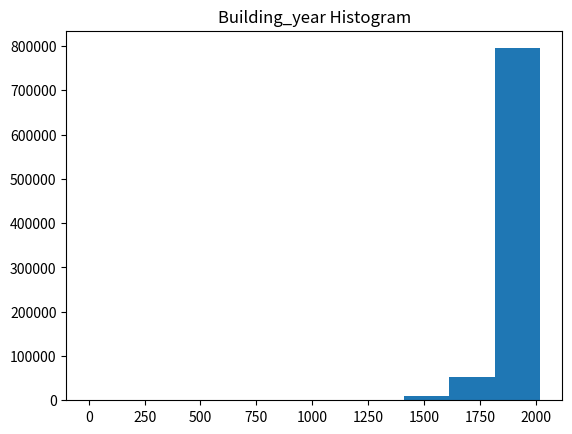

In [15]:
### builng_year_4의 분포를 확인해서, 값이 이상한 것은 조치를 취하자
plt.hist(x = df['building_year_4']
         , bins = 10
         )
plt.title('Building_year Histogram')

# 건물 연식이 1950년 미만인 것은 삭제하자
print(f"1950년 미만 데이터 개수 : {df[df['building_year_4'] < 1950].shape[0]}")

df = df[df['building_year_4'] > 1950]

print(f"1950년 미만 삭제 후 데이터 개수 : {df.shape[0]}")

Text(0.5, 1.0, 'After removing the old buildings')

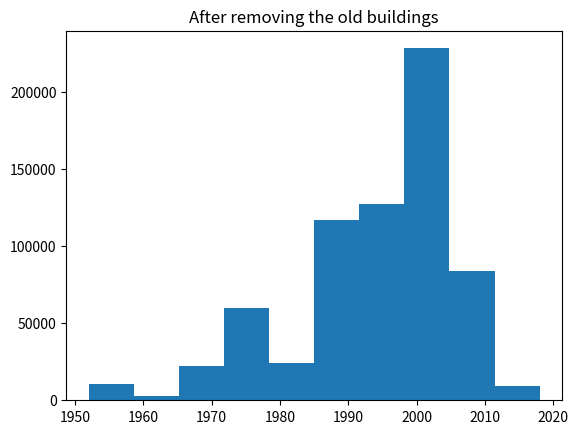

In [16]:
plt.hist(df['building_year_4']
         , bins = 10)

plt.title('After removing the old buildings')

In [17]:
# 10년마다 년대 구분해서 원핫 인코딩 하자
df['building_year_range'] = (df['building_year_4']//10) * 10
df['building_year_range'] = df['building_year_range'].astype('int').astype('object')
df.drop('building_year_4', axis =1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685819 entries, 0 to 856309
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sumbit_year          685819 non-null  object 
 1   jachigu_code         685819 non-null  object 
 2   law_code             685819 non-null  object 
 3   building_price       685819 non-null  int64  
 4   building_size        685819 non-null  float64
 5   building_year        685819 non-null  object 
 6   building_usage       685819 non-null  object 
 7   building_year_range  685819 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 47.1+ MB


In [18]:
df.drop('building_year', axis = 1, inplace = True)

In [19]:
# 다른 컬럼 특이사항 확인
print(df['jachigu_code'].unique())
print(df['law_code'].unique())
print(df['building_usage'].unique())

['11710' '11230' '11590' '11500' '11380' '11320' '11440' '11680' '11470'
 '11260' '11560' '11350' '11410' '11620' '11290' '11215' '11530' '11650'
 '11305' '11740' '11545' '11200' '11170' '11140' '11110']
['10500' '10600' '10200' '10300' '12300' '11100' '12500' '10700' '10900'
 '11900' '10400' '10100' '13600' '11000' '10800' '12200' '12800' '12600'
 '12000' '11700' '12100' '13300' '13500' '13000' '13100' '11200' '11300'
 '11500' '15100' '11800' '11400' '16500' '16000' '17400' '12700' '13400'
 '12900' '16200' '17500' '16300' '16800' '13700' '12400' '14700' '14900'
 '17300' '13200' '14000' '16600' '16700' '18600' '18300' '18400' '16900'
 '18700' '17100' '13900' '14300' '15700' '11600' '18200' '17200' '15900'
 '18100' '17000' '14400' '18500' '15300' '14800' '14600' '16400' '14500'
 '14200' '13800' '15200' '15400' '15500' '15800' '16100' '14100' '15000']
['연립다세대' '오피스텔' '아파트' '단독다가구']


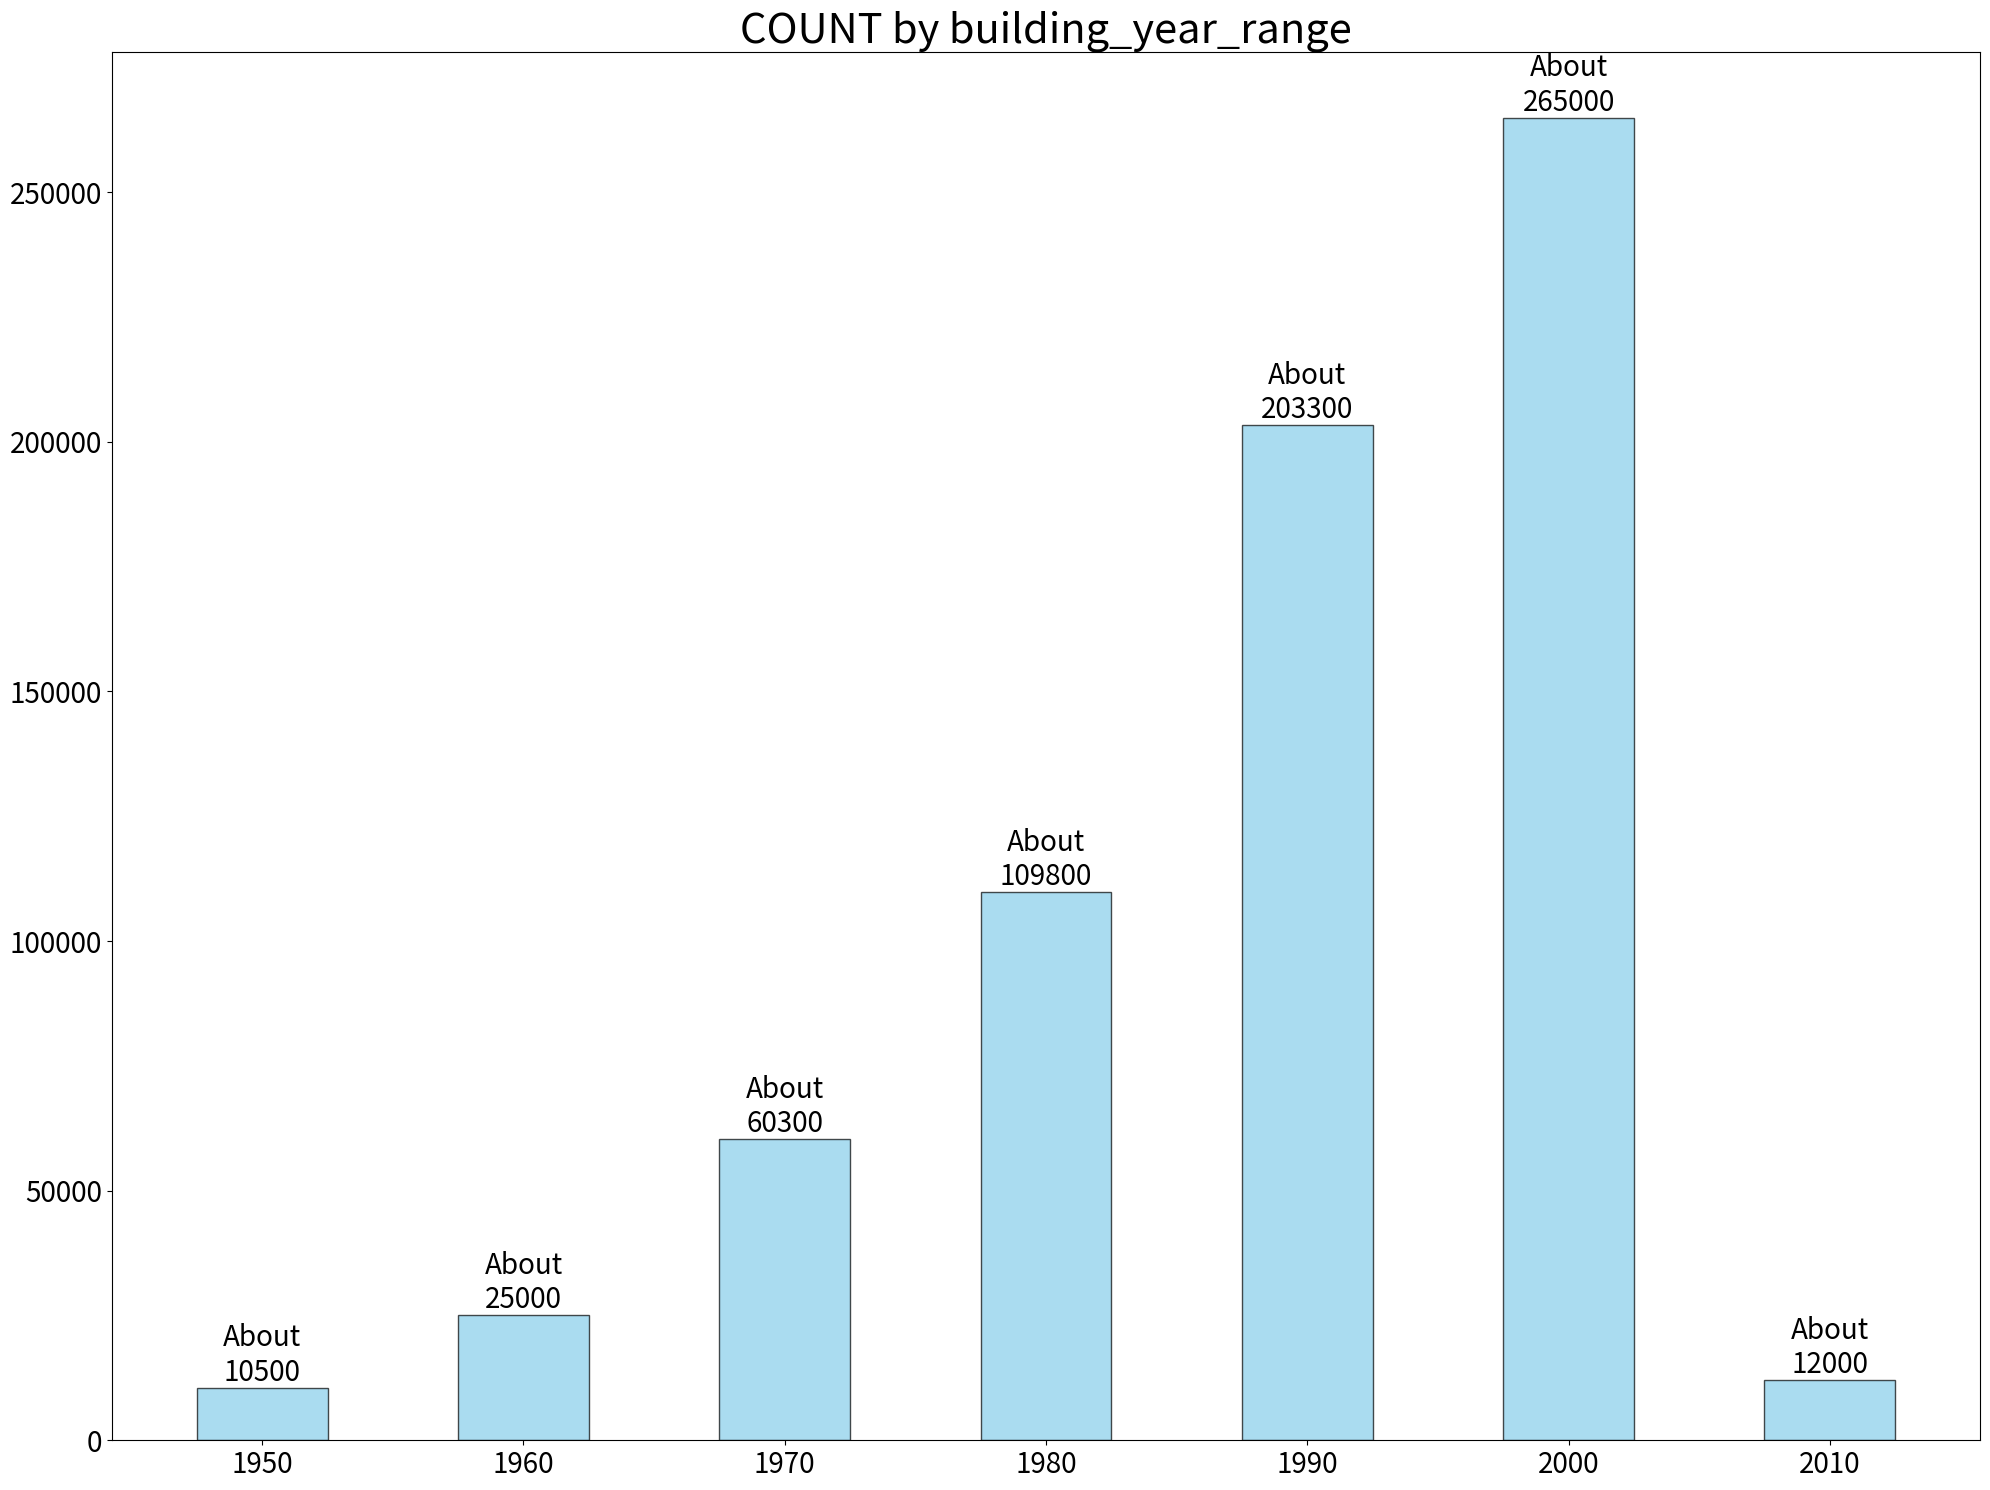

In [20]:
plt.figure(figsize=(20, 15))

charts = plt.bar(x = sorted(df['building_year_range'].unique())
                , height = df['building_year_range'].value_counts().sort_index()
                , width= 5
                , color = 'skyblue'
                , edgecolor = 'black'
                , alpha = 0.7
                )


for data in charts:
    plt.text(
        data.get_x() + data.get_width() / 2
        , data.get_height() + 0.5
        , f'''About
{round(int(data.get_height()), -2)}'''
        , ha = 'center'
        , va = 'bottom'
        , fontsize = 20
    )

plt.title('COUNT by building_year_range', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()


In [21]:
list(sorted(df['sumbit_year'].unique()))

['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

In [22]:
df.groupby(['sumbit_year', 'jachigu_code']).mean().reset_index()

,sumbit_year,jachigu_code,building_price,building_size
0,2017,11110,47572.083891,78.046252
1,2017,11140,54810.145858,79.185222
2,2017,11170,87191.657541,91.797341
3,2017,11200,59516.990213,83.228151
4,2017,11215,50742.126516,83.145979
...,...,...,...,...
195,2024,11620,51895.714998,65.944693
196,2024,11650,126639.292747,69.771343
197,2024,11680,201668.620729,84.183125
198,2024,11710,124672.812409,73.240167


In [23]:
df[df['building_year_range'].isnull() == True]['building_year_range']

Series([], Name: building_year_range, dtype: object)

In [24]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685819 entries, 0 to 856309
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sumbit_year          685819 non-null  object 
 1   jachigu_code         685819 non-null  object 
 2   law_code             685819 non-null  object 
 3   building_price       685819 non-null  int64  
 4   building_size        685819 non-null  float64
 5   building_usage       685819 non-null  object 
 6   building_year_range  685819 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 41.9+ MB


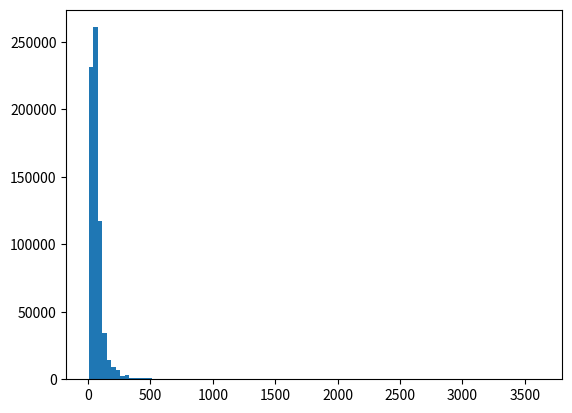

In [25]:
### building_size Feature Engineering
plt.hist(df['building_size']
         , bins = 100)
plt.show()

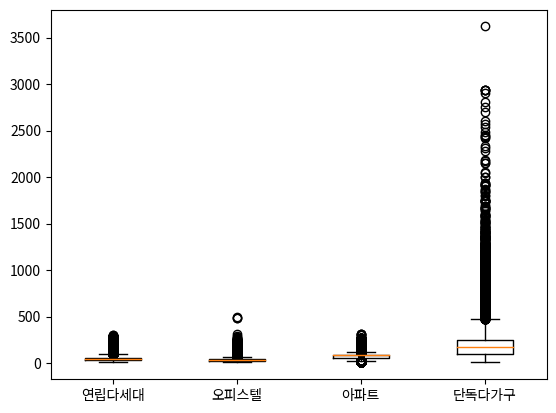

In [26]:
plt.boxplot([df[df['building_usage'] == i]['building_size'] for i in df['building_usage'].unique()]
            , labels = df['building_usage'].unique()
            )

plt.show()

In [27]:
tmp_df = df.copy()

In [28]:
# 건물 용도별로 이상치를 제거하자(너무 큰 평수나 너무 작은 평수)
quantitle_dict = {}
for i in tmp_df['building_usage'].unique():
    quantitle_dict[i] = tmp_df[tmp_df['building_usage'] == i]['building_size'].quantile([0.25, 0.75]).to_dict()
quantitle_dict

{'연립다세대': {0.25: 33.29, 0.75: 57.33},
 '오피스텔': {0.25: 22.58, 0.75: 39.0},
 '아파트': {0.25: 59.49, 0.75: 84.97},
 '단독다가구': {0.25: 93.6575, 0.75: 246.96}}

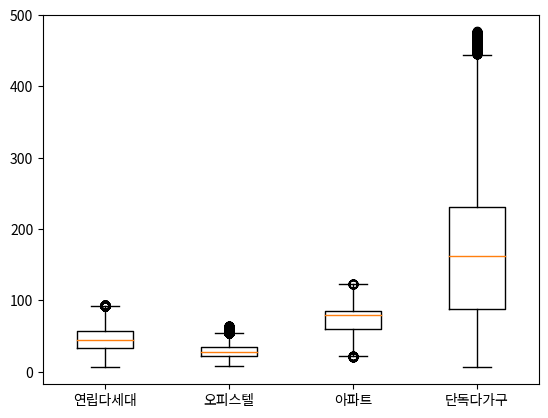

In [29]:
tmp_datas = []
tmp_labels = []
filtered_dfs = []
for i in df['building_usage'].unique():
    con1 = quantitle_dict[i][0.25] - 1.5 * (quantitle_dict[i][0.75] - quantitle_dict[i][0.25])
    con2 = quantitle_dict[i][0.75] + 1.5 * (quantitle_dict[i][0.75] - quantitle_dict[i][0.25])
    tmp_df = df[df['building_usage'] == i][(df['building_size'] > con1) & (df['building_size'] < con2)]
    filtered_dfs.append(tmp_df) # 조건 걸려진 df 합치기용
    tmp_datas.append(tmp_df['building_size'])
    tmp_labels.append(i)

res_df = pd.concat(filtered_dfs) # 조건 걸려진 df 합치기
plt.boxplot(tmp_datas
            , labels = tmp_labels)

plt.show()


▶ 원본 df
mean    69.278995
std     69.974175
50%     55.250000
Name: building_size, dtype: float64

▶ 건물 용도별 이상치 제거 df
mean    63.615957
std     49.384421
50%     53.420000
Name: building_size, dtype: float64



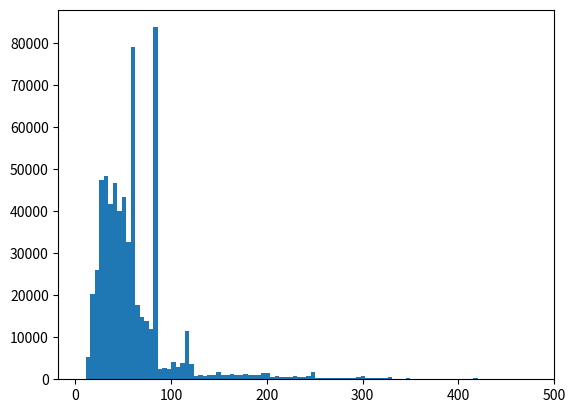

In [30]:
print(f'''
▶ 원본 df
{df.describe().loc[['mean', 'std', '50%'], 'building_size']}

▶ 건물 용도별 이상치 제거 df
{res_df.describe().loc[['mean', 'std', '50%'], 'building_size']}
''')
plt.hist(res_df['building_size']
         , bins = 100)

plt.show()

### 인코딩
- 'sumbit_year' => 숫자 데이터 그대로
- 'jachigu_code' => 범주형 (라벨링)
- 'law_code' => 범주형 (라벨링)
- 'building_price' => Target, 숫자형
- 'building_size'  => StandardScaler, MinMaxScaler, log 변환
- 'building_usage' => 라벨인코딩 + 원핫인코딩
- 'building_year_range' => 라벨인코딩 + 원핫인코딩

In [31]:
origin_encode_df = res_df.copy()

In [32]:
# 접수연도 숫자형(연속성을 보기 위해)
origin_encode_df['sumbit_year'] = origin_encode_df['sumbit_year'].astype('int64')

# 라벨 인코딩 컬럼
labels_encode = ['jachigu_code', 'law_code', 'building_usage', 'building_year_range']

# 라벨 인코더 저장
labels_save = {}

for i in labels_encode:
    le = LabelEncoder()
    origin_encode_df[f'Label_{i}'] = le.fit_transform(origin_encode_df[i])
    labels_save[i] = le

origin_encode_df

,sumbit_year,jachigu_code,law_code,building_price,building_size,building_usage,building_year_range,Label_jachigu_code,Label_law_code,Label_building_usage,Label_building_year_range
0,2017,11710,10500,42000,73.12,연립다세대,2000,23,4,2,5
1,2017,11710,10500,46600,66.93,연립다세대,2000,23,4,2,5
2,2017,11710,10500,19805,33.07,연립다세대,2000,23,4,2,5
3,2018,11710,10500,35500,59.82,연립다세대,2000,23,4,2,5
4,2017,11710,10500,30500,61.50,연립다세대,2000,23,4,2,5
...,...,...,...,...,...,...,...,...,...,...,...
856305,2020,11140,12800,140000,59.50,단독다가구,1950,1,27,0,0
856306,2023,11140,12800,200000,216.76,단독다가구,1950,1,27,0,0
856307,2020,11140,14000,150000,201.79,단독다가구,1960,1,39,0,1
856308,2024,11110,12800,140000,49.59,단독다가구,1950,0,27,0,0


In [33]:
encode_df = origin_encode_df.drop(labels_encode, axis =1)
encode_df

,sumbit_year,building_price,building_size,Label_jachigu_code,Label_law_code,Label_building_usage,Label_building_year_range
0,2017,42000,73.12,23,4,2,5
1,2017,46600,66.93,23,4,2,5
2,2017,19805,33.07,23,4,2,5
3,2018,35500,59.82,23,4,2,5
4,2017,30500,61.50,23,4,2,5
...,...,...,...,...,...,...,...
856305,2020,140000,59.50,1,27,0,0
856306,2023,200000,216.76,1,27,0,0
856307,2020,150000,201.79,1,39,0,1
856308,2024,140000,49.59,0,27,0,0


In [34]:
# one hot encoding
one_hot_encode = ['Label_building_usage', 'Label_building_year_range']

for i in one_hot_encode:
    encode_df = pd.get_dummies(encode_df, columns = [i])
    
encode_df

,sumbit_year,building_price,building_size,Label_jachigu_code,Label_law_code,Label_building_usage_0,Label_building_usage_1,Label_building_usage_2,Label_building_usage_3,Label_building_year_range_0,Label_building_year_range_1,Label_building_year_range_2,Label_building_year_range_3,Label_building_year_range_4,Label_building_year_range_5,Label_building_year_range_6
0,2017,42000,73.12,23,4,0,0,1,0,0,0,0,0,0,1,0
1,2017,46600,66.93,23,4,0,0,1,0,0,0,0,0,0,1,0
2,2017,19805,33.07,23,4,0,0,1,0,0,0,0,0,0,1,0
3,2018,35500,59.82,23,4,0,0,1,0,0,0,0,0,0,1,0
4,2017,30500,61.50,23,4,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856305,2020,140000,59.50,1,27,1,0,0,0,1,0,0,0,0,0,0
856306,2023,200000,216.76,1,27,1,0,0,0,1,0,0,0,0,0,0
856307,2020,150000,201.79,1,39,1,0,0,0,0,1,0,0,0,0,0
856308,2024,140000,49.59,0,27,1,0,0,0,1,0,0,0,0,0,0


In [35]:
encode_df['building_price'] = encode_df['building_price'].astype('float64')
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642717 entries, 0 to 856309
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   sumbit_year                  642717 non-null  int64  
 1   building_price               642717 non-null  float64
 2   building_size                642717 non-null  float64
 3   Label_jachigu_code           642717 non-null  int32  
 4   Label_law_code               642717 non-null  int32  
 5   Label_building_usage_0       642717 non-null  uint8  
 6   Label_building_usage_1       642717 non-null  uint8  
 7   Label_building_usage_2       642717 non-null  uint8  
 8   Label_building_usage_3       642717 non-null  uint8  
 9   Label_building_year_range_0  642717 non-null  uint8  
 10  Label_building_year_range_1  642717 non-null  uint8  
 11  Label_building_year_range_2  642717 non-null  uint8  
 12  Label_building_year_range_3  642717 non-null  uint8  
 13 

In [36]:
# 3가지 변형(StandardScale, MinMaxScale, log1p)
trans_method = ['StandardScaler', 'MinMaxScale', 'log1p']
trans_cols = ['building_price', 'building_size']
standard_df = encode_df.copy()
minmax_df = encode_df.copy()
log1p_df = encode_df.copy()

for i in trans_method:
    if i == 'StandardScaler':
        for j in trans_cols:
            scaled_data = StandardScaler().fit_transform(encode_df[j].values.reshape(-1, 1))
            standard_df['StandardScaler_' + j] = scaled_data

    elif i == 'MinMaxScale':
        for j in trans_cols:
            scaled_data = MinMaxScaler().fit_transform(encode_df[j].values.reshape(-1, 1))
            minmax_df['MinMaxScale_' + j] = scaled_data

    elif i == 'log1p':
        for j in trans_cols:
            scaled_data = np.log1p(encode_df[j])
            log1p_df['log1p_' + j] = scaled_data

    else :
        print('error')

standard_df.drop(trans_cols, axis = 1, inplace = True)
minmax_df.drop(trans_cols, axis = 1, inplace = True)
log1p_df.drop(trans_cols, axis = 1, inplace = True)

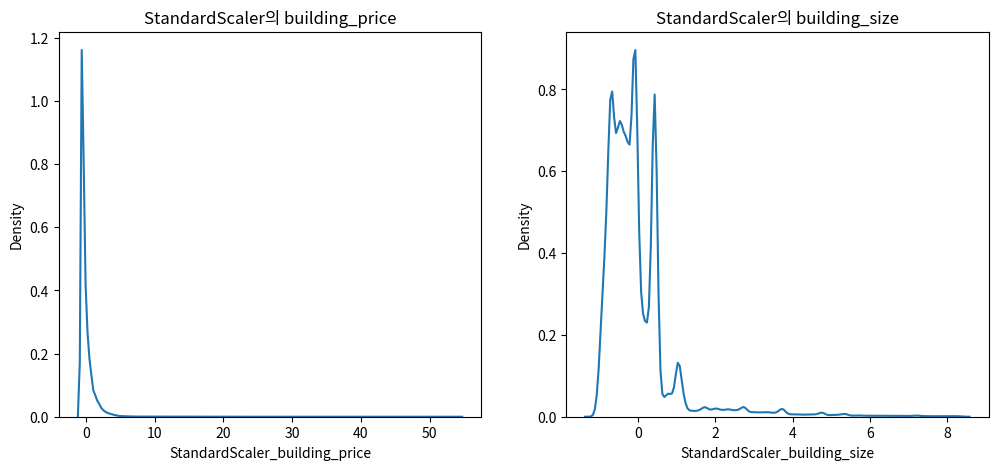

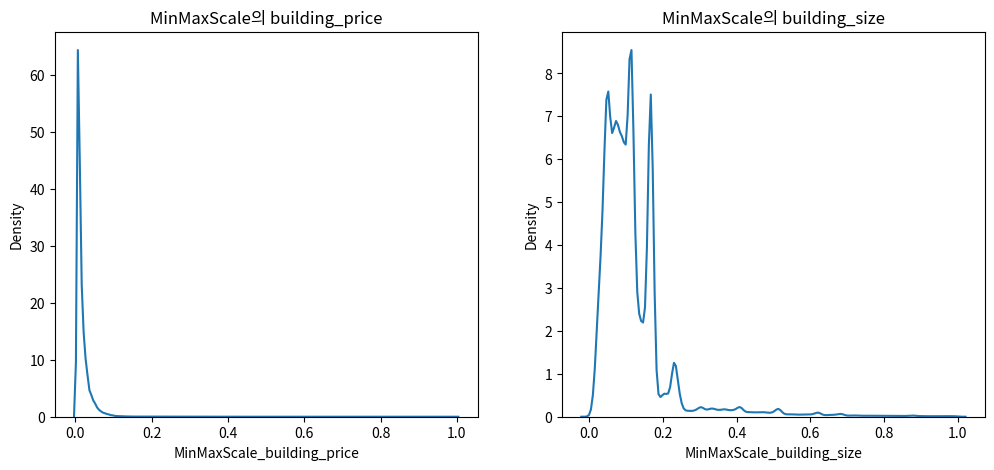

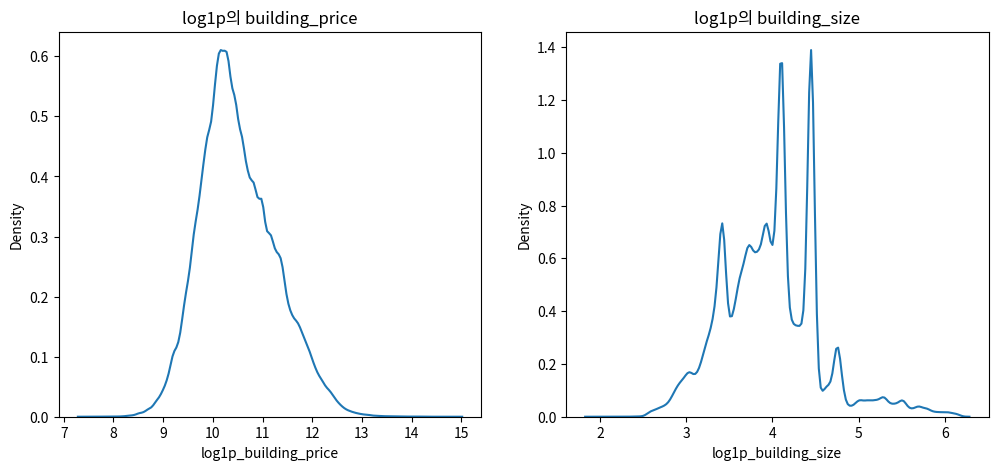

In [37]:
for num, i in enumerate([standard_df, minmax_df, log1p_df]):
    fig, axes = plt.subplots(figsize = (12, 5), nrows = 1, ncols=2)
    for num2, j in enumerate(trans_cols):    
        sns.kdeplot(i[trans_method[num] + '_' + j]
                    , ax= axes[num2]
                )
        axes[num2].set_title(f'{trans_method[num]}의 {j}')

    plt.show()


In [38]:
for i in trans_method:
    if i == 'StandardScaler':
        X_features_standard_df = standard_df.drop('StandardScaler_building_price', axis = 1)
        y_target_standard_df = standard_df['StandardScaler_building_price']

    elif i == 'MinMaxScale':
        X_features_minmax_df = minmax_df.drop('MinMaxScale_building_price', axis = 1)
        y_target_minmax_df = minmax_df['MinMaxScale_building_price']

    elif i == 'log1p':
        X_features_log1p_df = log1p_df.drop('log1p_building_price', axis = 1)
        y_target_log1p_df = log1p_df['log1p_building_price']

    else:
        print('error')

print(f'''
▶ StandardScaler
{X_features_standard_df.columns}, {y_target_standard_df.head(3)}

▶ MinMaxScaler
{X_features_minmax_df.columns}, {y_target_minmax_df.head(3)}

▶ log1p
{X_features_log1p_df.columns}, {y_target_log1p_df.head(3)}
''')


▶ StandardScaler
Index(['sumbit_year', 'Label_jachigu_code', 'Label_law_code',
       'Label_building_usage_0', 'Label_building_usage_1',
       'Label_building_usage_2', 'Label_building_usage_3',
       'Label_building_year_range_0', 'Label_building_year_range_1',
       'Label_building_year_range_2', 'Label_building_year_range_3',
       'Label_building_year_range_4', 'Label_building_year_range_5',
       'Label_building_year_range_6', 'StandardScaler_building_size'],
      dtype='object'), 0   -0.153377
1   -0.063849
2   -0.585348
Name: StandardScaler_building_price, dtype: float64

▶ MinMaxScaler
Index(['sumbit_year', 'Label_jachigu_code', 'Label_law_code',
       'Label_building_usage_0', 'Label_building_usage_1',
       'Label_building_usage_2', 'Label_building_usage_3',
       'Label_building_year_range_0', 'Label_building_year_range_1',
       'Label_building_year_range_2', 'Label_building_year_range_3',
       'Label_building_year_range_4', 'Label_building_year_range_5',
    

In [39]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = \
                                    train_test_split(X_features_standard_df
                                                    , y_target_standard_df
                                                    , test_size = 0.2
                                                    , random_state = 42)

X_train_minmax_df, X_test_minmax_df, y_train_minmax_df, y_test_minmax_df = \
                                    train_test_split(X_features_minmax_df
                                                    , y_target_minmax_df
                                                    , test_size = 0.2
                                                    , random_state = 42)

X_train_log1p_df, X_test_log1p_df, y_train_log1p_df, y_test_log1p_df = \
                                    train_test_split(X_features_log1p_df
                                                    , y_target_log1p_df
                                                    , test_size = 0.2
                                                    , random_state = 42)

print(f'''
{X_train_standard.shape[0], X_test_standard.shape[0], y_train_standard.shape[0], y_test_standard.shape[0]}
{X_train_minmax_df.shape[0], X_test_minmax_df.shape[0], y_train_minmax_df.shape[0], y_test_minmax_df.shape[0]}
{X_train_log1p_df.shape[0], X_test_log1p_df.shape[0], y_train_log1p_df.shape[0], y_test_log1p_df.shape[0]}
'''
)


(514173, 128544, 514173, 128544)
(514173, 128544, 514173, 128544)
(514173, 128544, 514173, 128544)



In [40]:
for num, i in enumerate(trans_method):
    if num == 0:
        std_y_pred = LinearRegression().fit(X_train_standard, y_train_standard).predict(X_test_standard)
        std_rmse = mean_squared_error(y_test_standard, std_y_pred, squared=False)
        std_r2 = r2_score(y_test_standard, std_y_pred)

    elif num == 1:
        minmax_y_pred = LinearRegression().fit(X_train_minmax_df, y_train_minmax_df).predict(X_test_minmax_df)
        minmax_rmse = mean_squared_error(y_test_minmax_df, minmax_y_pred, squared=False)
        minmax_r2 = r2_score(y_test_minmax_df, minmax_y_pred)        

    elif num == 2:
        log_y_pred = LinearRegression().fit(X_train_log1p_df, y_train_log1p_df).predict(X_test_log1p_df)
        log_rmse = mean_squared_error(y_test_log1p_df, log_y_pred, squared=False)
        log_r2 = r2_score(y_test_log1p_df, log_y_pred)

    else:
        print('error')
print(f'''
▶ {trans_method[0]}
- rmse : {std_rmse}
- r2 : {std_r2}

▶ {trans_method[1]}
- rmse : {minmax_rmse}
- r2 : {minmax_r2}

▶ {trans_method[2]}
- rmse : {log_rmse}
- r2 : {log_r2}      

{'*'* 50}
본 프로젝트에서는 log1p로 변환한 데이터프레임 사용 결정
{'*'* 50}
''')



▶ StandardScaler
- rmse : 0.719899120403724
- r2 : 0.48780549199578327

▶ MinMaxScale
- rmse : 0.012986327794486465
- r2 : 0.48780549199578405

▶ log1p
- rmse : 0.43247651467722975
- r2 : 0.6695813606143548      

**************************************************
본 프로젝트에서는 log1p로 변환한 데이터프레임 사용 결정
**************************************************



In [41]:
print(
    origin_encode_df.groupby(['building_usage', 'Label_building_usage']).count().reset_index()[origin_encode_df.groupby(['building_usage', 'Label_building_usage']).count().reset_index().columns[:2]]
)

print(
    origin_encode_df.groupby(['building_year_range', 'Label_building_year_range']).count().reset_index()[origin_encode_df.groupby(['building_year_range', 'Label_building_year_range']).count().reset_index().columns[:2]]
)


  building_usage  Label_building_usage
0          단독다가구                     0
1            아파트                     1
2          연립다세대                     2
3           오피스텔                     3
   building_year_range  Label_building_year_range
0                 1950                          0
1                 1960                          1
2                 1970                          2
3                 1980                          3
4                 1990                          4
5                 2000                          5
6                 2010                          6


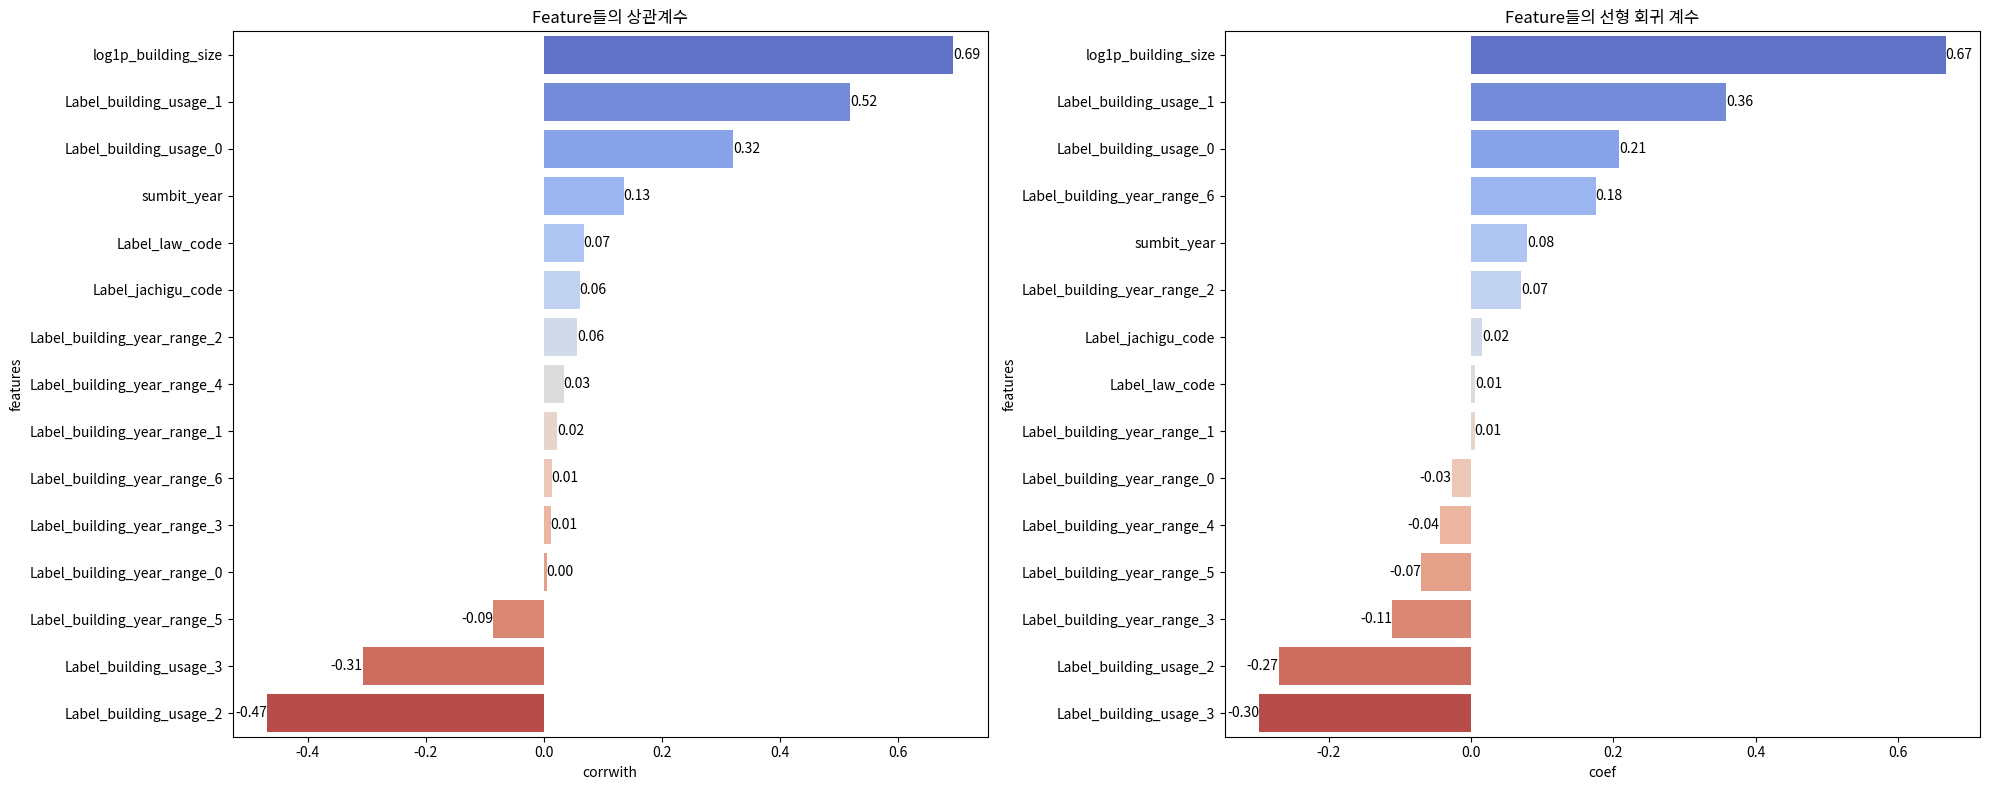

In [42]:
tmp_df = pd.DataFrame({
                    'features' : X_train_log1p_df.corrwith(y_train_log1p_df).keys()
                    , 'corrwith' : X_train_log1p_df.corrwith(y_train_log1p_df).values
                    }).sort_values(by = 'corrwith', ascending=False)

fig, (ax1, ax2) = plt.subplots(figsize=(20,8), nrows=1, ncols=2)
chart = sns.barplot(
                    data = tmp_df
                    , x = 'corrwith'
                    , y = 'features'
                    , palette = 'coolwarm'
                    , ax= ax1
                    )

for i in chart.containers:
    chart.bar_label(i, fmt='%.2f')

ax1.set_title('Feature들의 상관계수')

tmp_df = pd.DataFrame({
            'features' : X_train_log1p_df.columns
            , 'coef' : LinearRegression().fit(X_train_log1p_df, y_train_log1p_df).coef_
}).sort_values(by = 'coef', ascending=False)
chart = sns.barplot(
                    data = tmp_df
                    , x = 'coef'
                    , y = 'features'
                    , palette = 'coolwarm'
                    , ax = ax2
                    )

for i in chart.containers:
    chart.bar_label(i, fmt='%.2f')

ax2.set_title('Feature들의 선형 회귀 계수')
plt.tight_layout()
plt.show()

<Figure size 10000x6000 with 0 Axes>

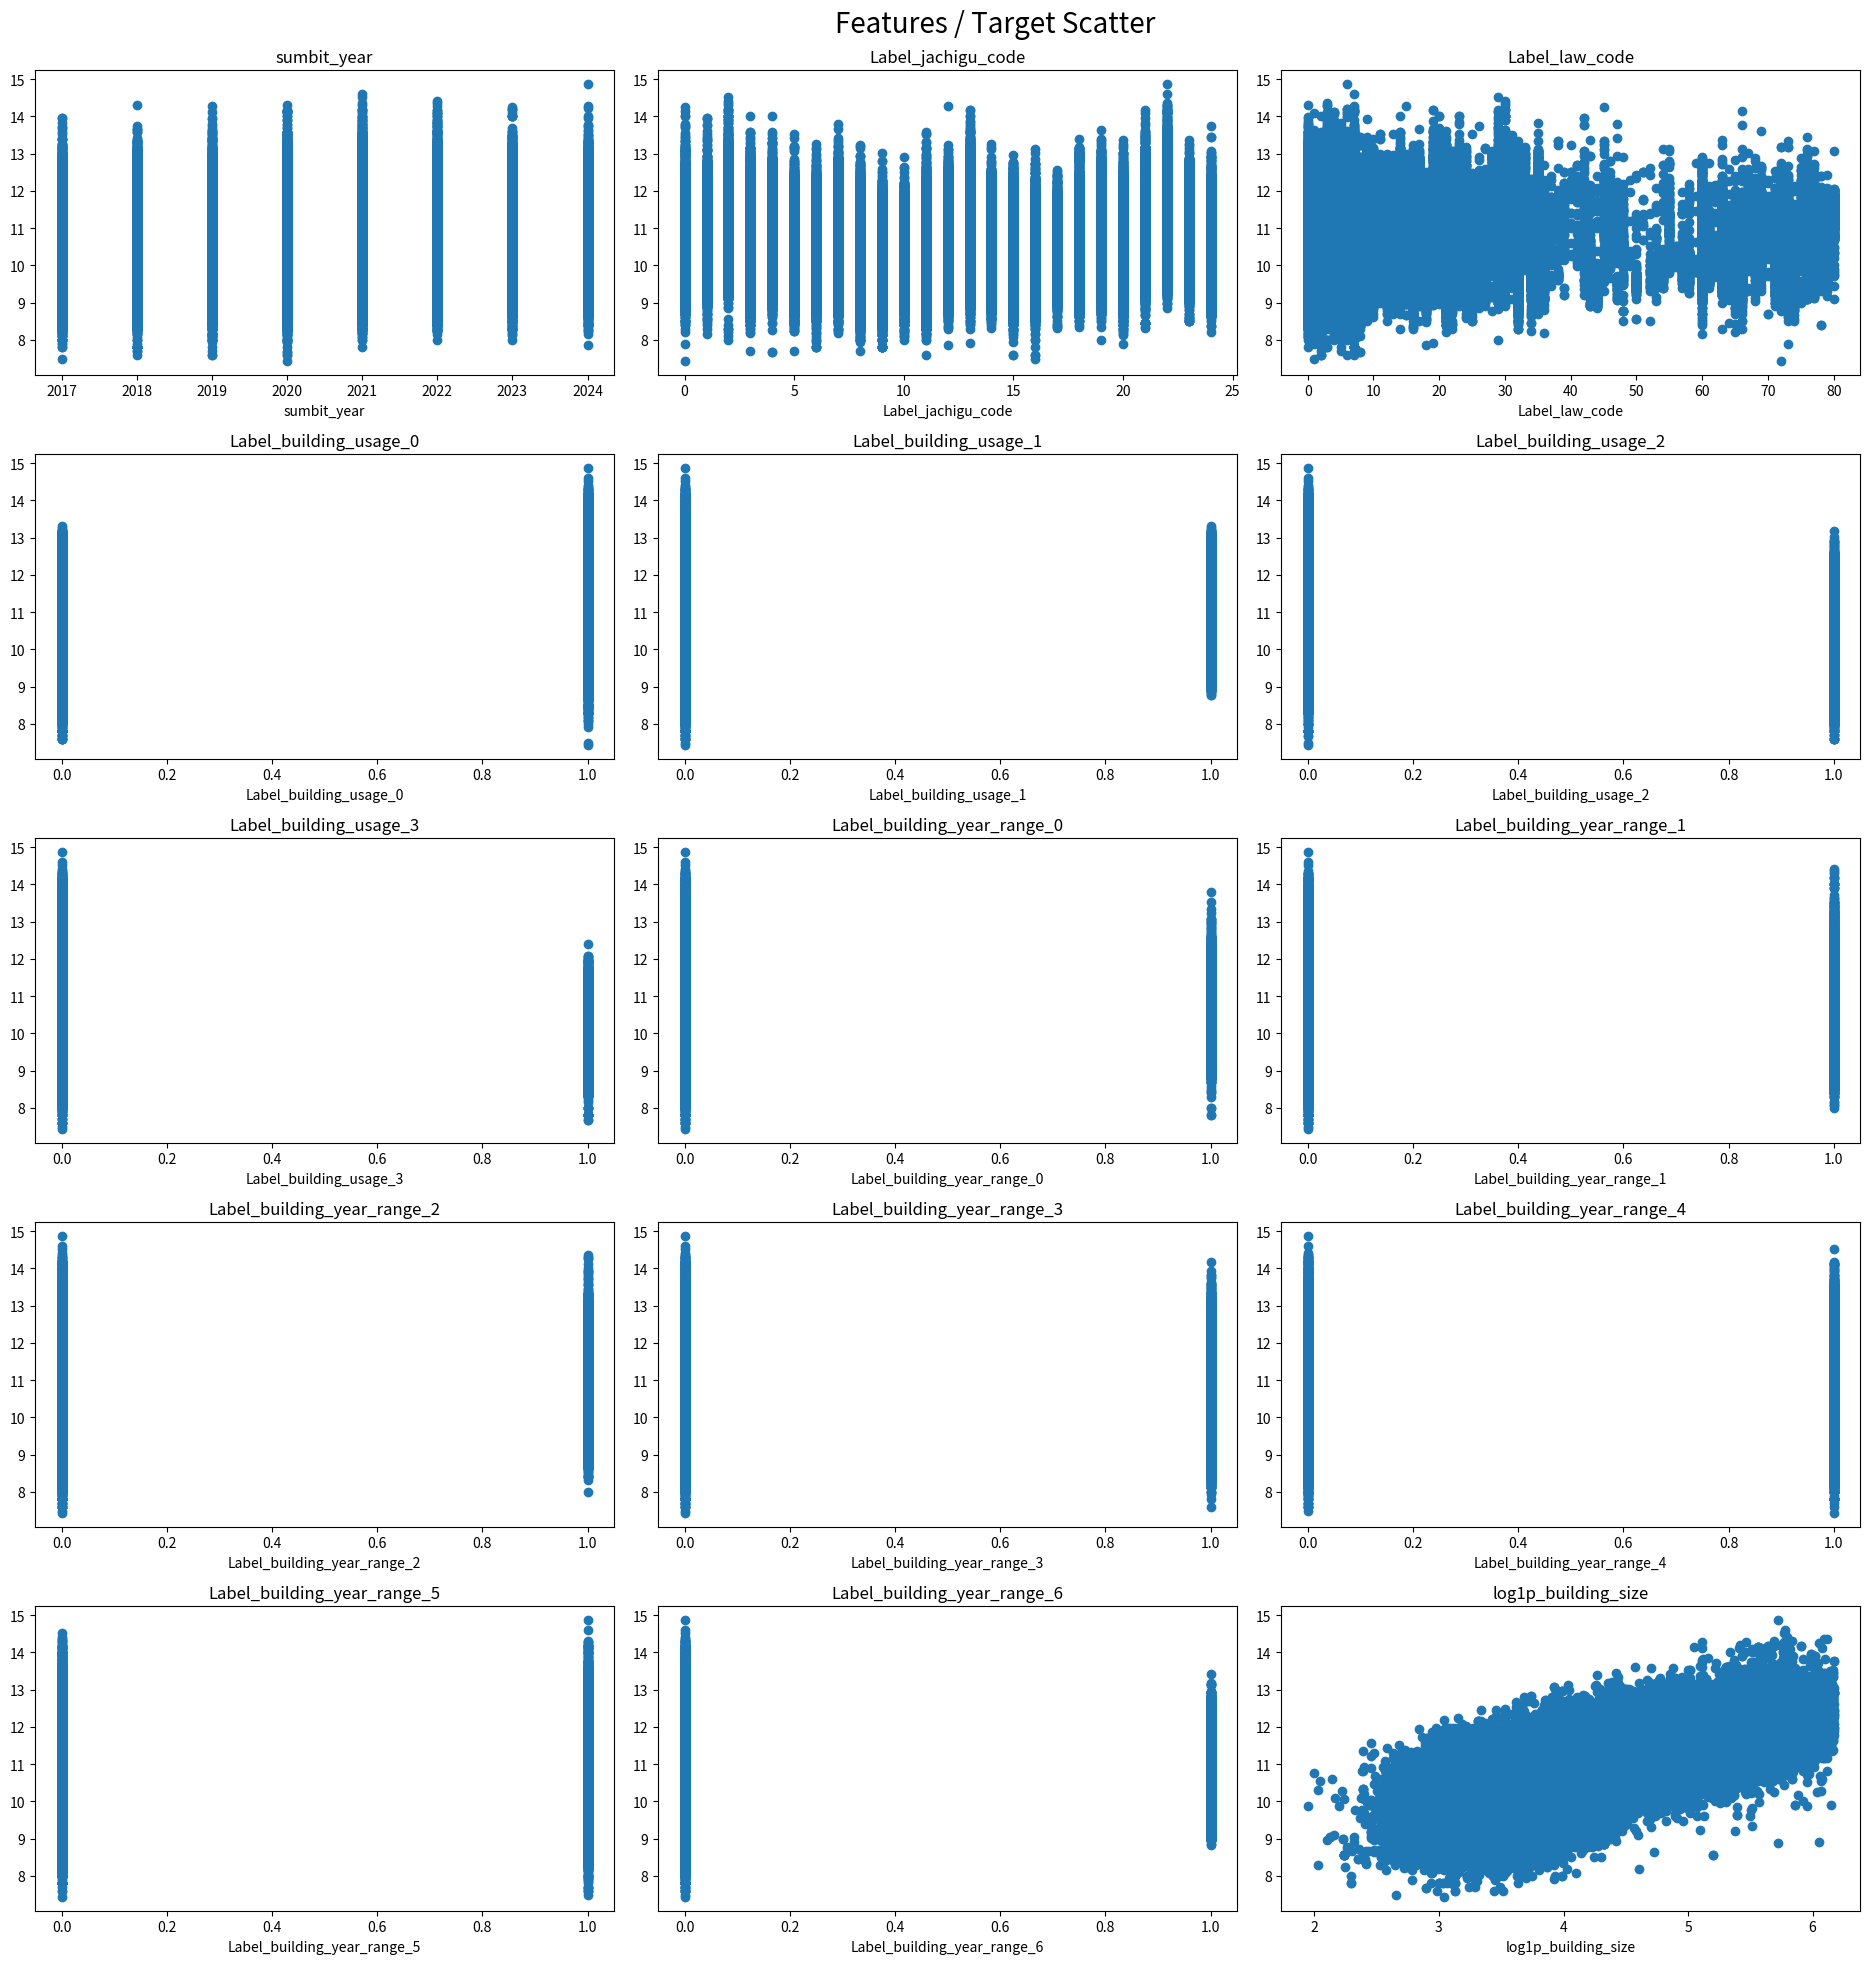

In [43]:
plt.figure(figsize = (100, 60))
fig, axes = plt.subplots(figsize = (20, 20), nrows = 5, ncols = 3)
axes = axes.flatten()

for num, i in enumerate(log1p_df.drop('log1p_building_price', axis= 1).columns):
    axes[num].scatter(x = log1p_df.drop('log1p_building_price', axis= 1)[i]
            , y = log1p_df['log1p_building_price']
            )
    axes[num].set_title(i)
    axes[num].set_xlabel(i)
    
plt.suptitle('Features / Target Scatter', fontsize = 20)
plt.tight_layout(rect=[0, 0, 0.94, 0.99])
plt.show()

### 4차 모델 개선 계획
1. 선형 모델 VS 비선형 모델의 피처를 다시 나누자
2. 선형 모델은 규제를 검토해보자
3. 비선형 모델들의 피처는 하이퍼파라미터 튜닝을 통해 최적의 모델을 만들자
4. 선형 모델의 예측과 비선형 모델의 예측에 각각 가중치를 곱해 최종 예측값을 구하자
5. 더해진 예측으로 최종적으로 r2_score를 구하자

궁금점
4번에서 가중치는 어떻게 정할까?
선형은 피처가 1개 인데, 영향이 크다

In [59]:
# 선형 모델 features / Target 구분
linear_X_features = log1p_df[['log1p_building_size']]
non_linear_X_featuers = log1p_df.drop(['log1p_building_size','log1p_building_price'], axis = 1)

y_target = log1p_df['log1p_building_price']

linear_X_train, linear_X_test, linear_y_train, linear_y_test = \
                                train_test_split(linear_X_features
                                                , y_target
                                                , random_state = 11
                                                , test_size = 0.2)

non_linear_X_train, non_linear_X_test, non_linear_y_train, non_linear_y_test = \
                                train_test_split(non_linear_X_featuers
                                                , y_target
                                                , random_state = 11
                                                , test_size = 0.2)

### 선형 feature 예측값 계산

In [60]:
linear_pred = LinearRegression().fit(linear_X_train, linear_y_train).predict(linear_X_test)
r2_score(linear_y_test, linear_pred)

0.48015888607969126

In [64]:
rf = RandomForestRegressor(random_state=11)
non_linear_pred = rf.fit(non_linear_X_train, non_linear_y_train).predict(non_linear_X_test)
r2_score(non_linear_y_test, non_linear_pred)

0.7333435185224442

In [72]:
final_pred = 0.7 * linear_pred + 0.3 * non_linear_pred
r2_score(linear_y_test, final_pred)

0.6664668554713528

In [73]:
rf = RandomForestRegressor(random_state=11)
pred = rf.fit(X_train_log1p_df, y_train_log1p_df).predict(X_test_log1p_df)
r2_score(y_test_log1p_df, pred)

0.8832874044800717